In [2]:
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .getOrCreate()

sc = spark.sparkContext

Creating RDD

In [3]:
ord = sc.textFile('/home/phillipefs/spark_dev/pyspark-end-to-end-developer/0 - PracticeFiles/Orders')
ord_items = sc.textFile('/home/phillipefs/spark_dev/pyspark-end-to-end-developer/0 - PracticeFiles/Order_items')

#### groupByKey(numPartitions=None, partitionFunc)</br>
- Can be used for aggregations but should be given low priority as it does not use the combiner.
- When called on a dataset of (K, V) pairs, returns a dataset of (K, Iterable<V>) pairs.
- If grouping in order to perform an aggregation (such as a sum or average) over each key, using reduceByKey or aggregateByKey will
yield much better performance.
- The number of reduce tasks is configurable through an optional argument – numPartitions

In [24]:
rdd_group = ord_items.map(lambda x : (int(x.split(',')[2]),float(x.split(',')[4])))
rdd_group = rdd_group.groupByKey()
rdd_group.mapValues(sum).take(5)

[(502, 3147800.0),
 (1014, 2888993.939999287),
 (926, 14870.69999999995),
 (134, 20025.0),
 (276, 29398.810000000012)]

Using map

In [26]:
rdd_group.map(lambda x : (x[0], sum(x[1]))).take(5)

[(502, 3147800.0),
 (1014, 2888993.939999287),
 (926, 14870.69999999995),
 (134, 20025.0),
 (276, 29398.810000000012)]

#### reduceByKey(func, numPartitions=None, partitionFunc)
- When called on a dataset of (K, V) pairs, returns a dataset of (K, V) pairs where the values for each key are aggregated using the given reduce
function func, which must be of type (V,V) => V.
- Like in groupByKey, the number of reduce tasks is configurable through an optional argument - numPartitions.
- It uses Combiner. Associative reduction. 


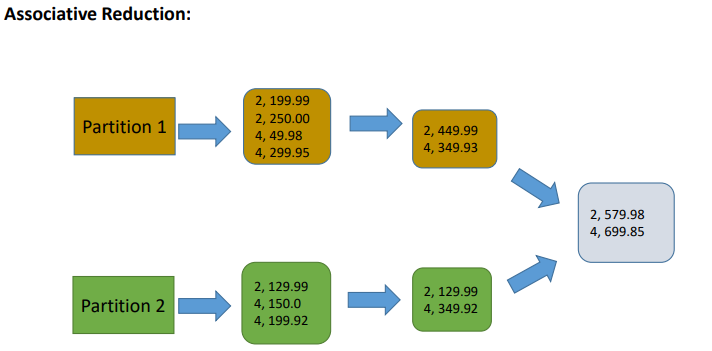

Example

In [32]:
rdd = sc.parallelize([('a',1), ('b',1), ('a',1)])
rdd.reduceByKey(lambda x, y : x + y).collect()

[('b', 1), ('a', 2)]

Find the total revenue sold for each order

In [39]:
ord_items.map(lambda x : (x.split(',')[1], float(x.split(',')[4]))).reduceByKey(lambda x , y : x + y).take(5)

[('1', 299.98),
 ('4', 699.85),
 ('8', 729.8399999999999),
 ('9', 599.96),
 ('10', 651.9200000000001)]

 Find the maximum revenue for each order

In [47]:
ord_items.map(lambda x : (x.split(',')[1], float(x.split(',')[4])))\
         .reduceByKey(lambda x , y : x if x > y else y).take(5)

[('1', 299.98), ('4', 299.95), ('8', 299.95), ('9', 199.99), ('10', 199.99)]

In [52]:
ord_items.map(lambda x : (x.split(',')[1],x)).reduceByKey(lambda x , y : x if (float(x.split(',')[4]) > float(y.split(',')[4])) else y).take(5)

[('1', '1,1,957,1,299.98,299.98'),
 ('4', '6,4,365,5,299.95,59.99'),
 ('8', '18,8,365,5,299.95,59.99'),
 ('9', '23,9,1073,1,199.99,199.99'),
 ('10', '28,10,1073,1,199.99,199.99')]

#### aggregateByKey(zeroValue, seqOp, combOp, (numPartitions)):
- First aggregate elements in each partition and then aggregating results of all partition to get the final result and the result could be any
type than the type of your RDD.
- 3 mandatory arguments:
    - Zero Value: Initial value to initialize the accumulator. Use 0 for integer and NULL for collections.
    - SeqOp: Function used to accumulate the results of each partition, and stores the running accumulated result to U. (U,T) => U.
    - CombOp: Function is used to combine results of all partitions U.


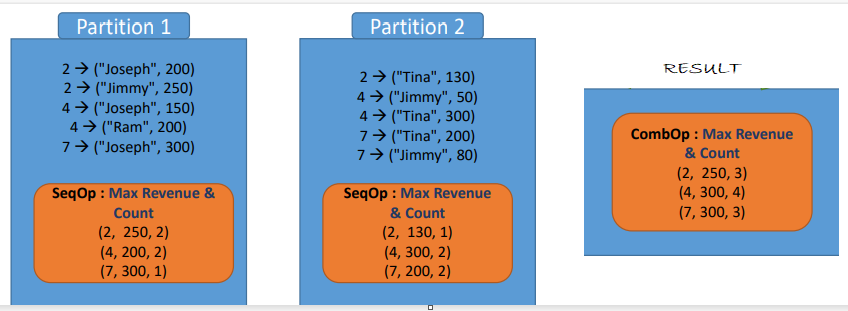


Example1 - Find the maximum revenue for each Order

In [55]:
ordItems=sc.parallelize([
(2,"Joseph",200), (2,"Jimmy",250), (2,"Tina",130), (4,"Jimmy",50), (4,"Tina",300),
(4,"Joseph",150), (4,"Ram",200), (7,"Tina",200), (7,"Joseph",300), (7,"Jimmy",80)],2)
#Create a Paired RDD

ordPair = ordItems.map(lambda x : (x[0],(x[1],x[2])))
zero_val = 0

def seq_op(acc, elem):
    if (acc > elem[1]):
        return acc
    else:
        return elem[1]
    
def comb_op(acc1, acc2):
    if (acc1 > acc2):
        return acc1
    else:
        return acc2
    
ordPair.aggregateByKey(zero_val, seq_op, comb_op).take(20)

[(2, 250), (4, 300), (7, 300)]

Example2 - Find the maximum revenue for each Order. Print customer name.

In [66]:
ordItems=sc.parallelize([
(2,"Joseph",200), (2,"Jimmy",250), (2,"Tina",130), (4,"Jimmy",50), (4,"Tina",300),
(4,"Joseph",150), (4,"Ram",200), (7,"Tina",200), (7,"Joseph",300), (7,"Jimmy",80)],2)
#Create a Paired RDD
ordPair = ordItems.map(lambda x : (x[0],(x[1],x[2])))
#Initialize Accumulator
# Zero Value: Zero value in our case will be 0 as we are finding Maximum Marks
zero_val=('',0)
#Define Sequence Operation
# Sequence operation : Finding Maximum revenue from each partition
def seq_op(accumulator, element):
    if(accumulator[1] > element[1]):
        return accumulator
    else:
        return element
#Define Combiner Operation
#Combiner Operation : Finding Maximum revenue from all partitions
def comb_op(accumulator1, accumulator2):
    if(accumulator1[1] > accumulator2[1]):
        return accumulator1
    else:
        return accumulator2

ordPair.aggregateByKey(zero_val, seq_op, comb_op).collect()

[(2, ('Jimmy', 250)), (4, ('Tina', 300)), (7, ('Joseph', 300))]